In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

In [ ]:
# Cargar datos
df = pd.read_csv('nuevos_datos.csv')

In [ ]:
# -----------------------------
# Convertir fechas
# -----------------------------
fechas = ['fechaCobroBanco', 'fechaEnvioCobro', 'fechaCreacionLista']
for col in fechas:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [ ]:
# -----------------------------
# Variable binaria de éxito
# -----------------------------
df['exito_cobro'] = (df['idRespuestaBanco'] == 0).astype(int)

# Tiempo de respuesta en horas
df['tiempo_respuesta_horas'] = (df['fechaCobroBanco'] - df['fechaEnvioCobro']).dt.total_seconds() / 3600

In [ ]:
# -----------------------------
# Eliminar columnas irrelevantes
# -----------------------------
columnas_eliminar = ['observaciones']
df = df.drop(columns=columnas_eliminar, errors='ignore')

In [ ]:
# -----------------------------
# Convertir rangos de hora a minutos
# -----------------------------
def calcular_duracion_minutos(rango):
    try:
        partes = re.findall(r'(\d{1,2}:\d{2})', rango)
        if len(partes) == 2:
            h_inicio = datetime.strptime(partes[0], "%H:%M")
            h_fin = datetime.strptime(partes[1], "%H:%M")
            duracion = (h_fin - h_inicio).seconds / 60
            return duracion
    except:
        return np.nan
    return np.nan

# Detectar columnas con formato '6:40 - 17:40'
for col in df.columns:
    if df[col].dtype == 'object' and df[col].str.contains(r'\d{1,2}:\d{2}\s*-\s*\d{1,2}:\d{2}', na=False).any():
        print(f"🕒 Convirtiendo columna '{col}' a minutos")
        df[col + '_minutos'] = df[col].apply(calcular_duracion_minutos)
        df.drop(columns=[col], inplace=True)

In [ ]:
# -----------------------------
# Rellenar NaNs numéricos con media
# -----------------------------
for col in df.select_dtypes(include='number').columns:
    df[col] = df[col].fillna(df[col].mean())

In [ ]:
# -----------------------------
# Codificar variables categóricas
# -----------------------------
categoricas = ['idBanco', 'idEmisora', 'month']
df = pd.get_dummies(df, columns=[col for col in categoricas if col in df.columns], drop_first=True)

In [ ]:
# -----------------------------
# Crear variable de eficiencia (si 'Costo' está presente)
# -----------------------------
if 'Costo' in df.columns:
    df['costo_norm'] = (df['Costo'] - df['Costo'].min()) / (df['Costo'].max() - df['Costo'].min())
    df['eficiencia'] = df['exito_cobro'] * (1 - df['costo_norm'])

In [ ]:
# -----------------------------
# Guardar archivo preprocesado
# -----------------------------
df.to_csv('datos_cobros_preprocesado2.csv', index=False)
print("✅ Archivo preprocesado guardado como 'datos_cobros_preprocesado2.csv'")


<ipython-input-6-d8f5d2cdd160>:7: DtypeWarning: Columns (7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('nuevos_datos.csv')


🕒 Convirtiendo columna 'Horario Limite Carga' a minutos
🕒 Convirtiendo columna 'Horario de cobro' a minutos
✅ Archivo preprocesado guardado como 'datos_cobros_preprocesado2.csv'


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, mean_squared_error
import joblib

In [ ]:

# -----------------------------
# Cargar datos
# -----------------------------
df = pd.read_csv('datos_cobros_preprocesado.csv')

# -----------------------------
# Definir variables
# -----------------------------
X = df.drop(columns=['idListaCobro', 'idCredito', 'consecutivoCobro',
                     'fechaCobroBanco', 'fechaEnvioCobro', 'fechaCreacionLista',
                     'exito_cobro', 'eficiencia'], errors='ignore')

y_clf = df['exito_cobro']
y_reg = df['eficiencia']

# Identificar columnas numéricas y categóricas
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

# -----------------------------
# Preprocesamiento
# -----------------------------
preprocesamiento = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# -----------------------------
# Pipeline clasificación
# -----------------------------
clf_pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocesamiento),
    ('clasificador', LogisticRegression(max_iter=1000))
])

# -----------------------------
# Pipeline regresión
# -----------------------------
reg_pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocesamiento),
    ('regresor', LinearRegression())
])

# -----------------------------
# Entrenamiento
# -----------------------------
clf_pipeline.fit(X, y_clf)
reg_pipeline.fit(X, y_reg)

# -----------------------------
# Evaluación
# -----------------------------
y_pred = clf_pipeline.predict(X)
print("=== Clasificación ===")
print(classification_report(y_clf, y_pred))

y_pred_reg = reg_pipeline.predict(X)
mse = mean_squared_error(y_reg, y_pred_reg)
print(f"=== Regresión MSE: {mse:.4f} ===")

# -----------------------------
# Guardar modelos
# -----------------------------
joblib.dump(clf_pipeline, 'modelo_exito_cobro.pkl')
joblib.dump(reg_pipeline, 'modelo_eficiencia.pkl')
print("✅ Modelos guardados.")


<ipython-input-5-601012161da0>:14: DtypeWarning: Columns (7,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datos_cobros_preprocesado.csv')


=== Clasificación ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5693654
           1       1.00      1.00      1.00    207240

    accuracy                           1.00   5900894
   macro avg       1.00      1.00      1.00   5900894
weighted avg       1.00      1.00      1.00   5900894

=== Regresión MSE: 0.0057 ===
✅ Modelos guardados.


In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

def preprocesar_datos(df):
    # Convertir columnas de fecha si existen
    fechas = ['fechaCobroBanco', 'fechaEnvioCobro', 'fechaCreacionLista']
    for col in fechas:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Crear variable binaria de éxito
    if 'idRespuestaBanco' in df.columns:
        df['exito_cobro'] = (df['idRespuestaBanco'] == 0).astype(int)

    # Calcular tiempo de respuesta en horas
    if 'fechaCobroBanco' in df.columns and 'fechaEnvioCobro' in df.columns:
        df['tiempo_respuesta_horas'] = (df['fechaCobroBanco'] - df['fechaEnvioCobro']).dt.total_seconds() / 3600

    # Eliminar columnas innecesarias
    columnas_eliminar = ['observaciones']
    df = df.drop(columns=[col for col in columnas_eliminar if col in df.columns], errors='ignore')

    # Convertir rangos de hora (por ejemplo '07:00 - 08:00') a minutos
    def calcular_duracion_minutos(rango):
        try:
            partes = re.findall(r'(\d{1,2}:\d{2})', rango)
            if len(partes) == 2:
                h_inicio = datetime.strptime(partes[0], "%H:%M")
                h_fin = datetime.strptime(partes[1], "%H:%M")
                duracion = (h_fin - h_inicio).seconds / 60
                return duracion
        except:
            return np.nan
        return np.nan

    for col in df.columns:
        if df[col].dtype == 'object' and df[col].str.contains(r'\d{1,2}:\d{2}\s*-\s*\d{1,2}:\d{2}', na=False).any():
            df[col + '_minutos'] = df[col].apply(calcular_duracion_minutos)
            df.drop(columns=[col], inplace=True)

    # Rellenar NaNs numéricos con la media
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].fillna(df[col].mean())

    # Crear variables de costo normalizado y eficiencia si existe 'Costo'
    if 'Costo' in df.columns:
        df['costo_norm'] = (df['Costo'] - df['Costo'].min()) / (df['Costo'].max() - df['Costo'].min())
        df['eficiencia'] = df.get('exito_cobro', 1) * (1 - df['costo_norm'])

    return df


In [ ]:
nuevos_datos = pd.read_csv('nuevos_datos.csv')
nuevos_datos = preprocesar_datos(nuevos_datos)

X_nuevo = nuevos_datos.drop(columns=[
    'idListaCobro', 'idCredito', 'consecutivoCobro',
    'fechaCobroBanco', 'fechaEnvioCobro', 'fechaCreacionLista',
    'exito_cobro', 'eficiencia'
], errors='ignore')

nuevos_datos['pred_exito_cobro'] = clf_pipeline.predict(X_nuevo)
nuevos_datos['proba_exito_cobro'] = clf_pipeline.predict_proba(X_nuevo)[:, 1]
nuevos_datos['pred_eficiencia'] = reg_pipeline.predict(X_nuevo)


<ipython-input-13-14de8063dbc1>:1: DtypeWarning: Columns (7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  nuevos_datos = pd.read_csv('nuevos_datos.csv')


In [ ]:
nuevos_datos.to_csv('predicciones_nuevos_datos.csv', index=False)


In [ ]:
predicciones_nuevos_datos=pd.read_csv('predicciones_nuevos_datos.csv')

<ipython-input-16-52f78ac4eda8>:1: DtypeWarning: Columns (7,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  predicciones_nuevos_datos=pd.read_csv('predicciones_nuevos_datos.csv')


In [ ]:
predicciones_nuevos_datos.describe()

,Unnamed: 0,idListaCobro,idCredito,consecutivoCobro,montoExigible,montoCobrar,montoCobrado,idRespuestaBanco,idBanco,idEmisora,...,month,exito_cobro,tiempo_respuesta_horas,Horario Limite Carga_minutos,Horario de cobro_minutos,costo_norm,eficiencia,pred_exito_cobro,proba_exito_cobro,pred_eficiencia
count,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,...,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06,2.114172e+06
mean,1.057086e+06,1.589950e+05,6.660354e+05,4.281485e+07,6.215732e+02,6.215732e+02,3.504571e+01,3.874330e+00,1.028498e+01,8.943457e+00,...,1.017363e+01,4.211294e-02,3.193902e+02,5.393664e+02,5.646770e+02,1.141952e-01,2.070497e-02,4.211294e-02,4.205912e-02,3.433971e-02
std,6.103090e+05,1.708906e+03,8.756013e+04,8.290130e+05,6.738359e+02,6.738359e+02,2.543225e+02,1.106792e+00,1.257896e+01,7.044407e+00,...,1.232396e+00,2.008469e-01,6.241266e+01,1.808287e+02,1.646355e+02,1.516575e-01,1.167601e-01,2.008469e-01,2.004473e-01,8.707458e-02
min,0.000000e+00,1.559380e+05,9.872000e+03,4.139643e+07,1.000000e-02,1.000000e-02,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,...,1.000000e+00,0.000000e+00,-1.464000e+03,4.190000e+02,6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.447298e-118,-2.068865e+00
25%,5.285428e+05,1.574440e+05,6.540640e+05,4.205686e+07,2.411800e+02,2.411800e+02,0.000000e+00,4.000000e+00,2.000000e+00,5.000000e+00,...,1.017363e+01,0.000000e+00,3.193902e+02,4.190000e+02,4.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.171606e-05,6.997580e-03
50%,1.057086e+06,1.590310e+05,6.926270e+05,4.282827e+07,4.112900e+02,4.112900e+02,0.000000e+00,4.000000e+00,1.200000e+01,6.000000e+00,...,1.017363e+01,0.000000e+00,3.193902e+02,4.500000e+02,5.646770e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.355900e-05,2.580919e-02
75%,1.585628e+06,1.604140e+05,7.153840e+05,4.354227e+07,7.492200e+02,7.492200e+02,0.000000e+00,4.000000e+00,1.200000e+01,1.300000e+01,...,1.017363e+01,0.000000e+00,3.193902e+02,6.600000e+02,5.646770e+02,2.187500e-01,0.000000e+00,0.000000e+00,4.065241e-05,2.975009e-02
max,2.114171e+06,1.622710e+05,7.565950e+05,4.429905e+07,3.226846e+04,3.226846e+04,3.226846e+04,8.800000e+01,7.200000e+01,2.500000e+01,...,1.200000e+01,1.000000e+00,5.136000e+03,8.700000e+02,8.550000e+02,1.000000e+00,7.812500e-01,1.000000e+00,1.000000e+00,8.286821e+00


In [ ]:
predicciones_nuevos_datos[predicciones_nuevos_datos['proba_exito_cobro'] == 1.0]

,Unnamed: 0,idListaCobro,idCredito,consecutivoCobro,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,idRespuestaBanco,fechaCreacionLista,...,month,exito_cobro,tiempo_respuesta_horas,Horario Limite Carga_minutos,Horario de cobro_minutos,costo_norm,eficiencia,pred_exito_cobro,proba_exito_cobro,pred_eficiencia
423,423,156037,737037,41406202,2341.33,2341.33,2341.33,2025-04-01,0.0,2025-03-01 09:44:00,...,3.000000,1,744.000000,870.0,564.677026,0.31250,0.68750,1,1.0,0.809265
445,445,156073,654210,41419049,2738.83,2738.83,2738.83,2025-09-01,0.0,2025-06-01 09:28:00,...,6.000000,1,2208.000000,870.0,564.677026,0.31250,0.68750,1,1.0,0.849212
449,449,156073,714981,41419052,2930.46,2930.46,2930.46,2025-09-01,0.0,2025-06-01 09:28:00,...,6.000000,1,2208.000000,870.0,564.677026,0.31250,0.68750,1,1.0,0.896938
451,451,156073,731199,41419054,3782.15,3782.15,3782.15,2025-09-01,0.0,2025-06-01 09:28:00,...,6.000000,1,2208.000000,870.0,564.677026,0.31250,0.68750,1,1.0,1.109055
453,453,156073,736453,41419057,2339.53,2339.53,2339.53,2025-08-01,0.0,2025-06-01 09:28:00,...,6.000000,1,1464.000000,870.0,564.677026,0.31250,0.68750,1,1.0,0.779774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111981,2111981,162127,747551,44252317,3782.15,3782.15,3782.15,NaN,0.0,NaN,...,10.173635,1,319.390153,419.0,420.000000,0.21875,0.78125,1,1.0,1.073285
2113192,2113192,162226,742776,44281351,2458.40,2458.40,2458.40,NaN,0.0,NaN,...,10.173635,1,319.390153,419.0,420.000000,0.21875,0.78125,1,1.0,0.743596
2113199,2113199,162226,753874,44281358,2889.08,2889.08,2889.08,NaN,0.0,NaN,...,10.173635,1,319.390153,419.0,420.000000,0.21875,0.78125,1,1.0,0.850858
2113416,2113416,162243,738692,44282969,3782.15,3782.15,3782.15,NaN,0.0,NaN,...,10.173635,1,319.390153,419.0,420.000000,0.21875,0.78125,1,1.0,1.073281


In [ ]:
d2025=pd.read_csv('nuevos_datos.csv')

<ipython-input-19-70db31798c56>:1: DtypeWarning: Columns (7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  d2025=pd.read_csv('nuevos_datos.csv')


In [ ]:
d2025[(d2025['idListaCobro'] == 162243)&(d2025['idCredito'] == 740630)]

,Unnamed: 0,idListaCobro,idCredito,consecutivoCobro,montoExigible,montoCobrar,montoCobrado,fechaCobroBanco,idRespuestaBanco,fechaCreacionLista,idBanco,fechaEnvioCobro,idEmisora,Costo,Horario Limite Carga,Horario de cobro,observaciones,month
2113419,2113419,162243,740630,44282972,3302.19,3302.19,3302.19,21/05/2025,0.0,21/05/2025 9:27AM,2,NaN,5,1.75,8:00 - 14:59,8:00 - 15:00,30 min,NaN


<ipython-input-24-b6bfb1d1e93c>:5: DtypeWarning: Columns (7,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('predicciones_nuevos_datos.csv')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


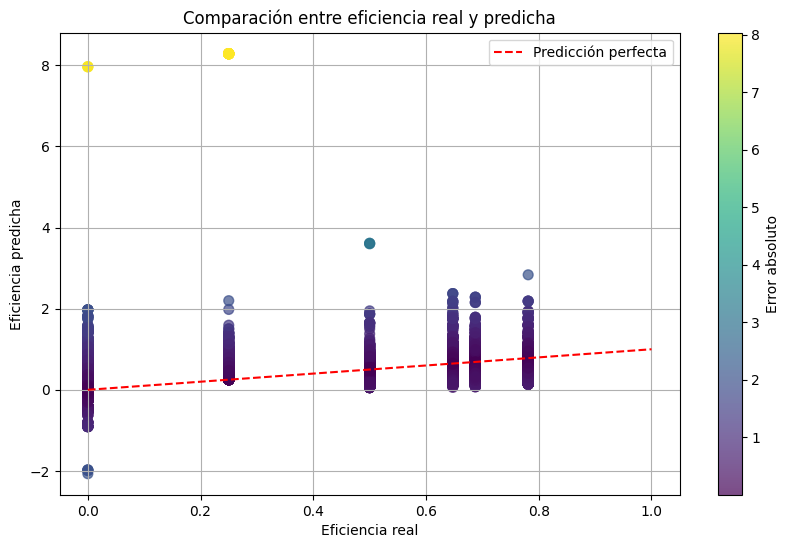

Desviación media absoluta: 0.0360


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv('predicciones_nuevos_datos.csv')

# Asegurar que las columnas necesarias existen
if 'eficiencia' in df.columns and 'pred_eficiencia' in df.columns:
    # Calcular el error absoluto
    df['error_absoluto'] = abs(df['eficiencia'] - df['pred_eficiencia'])

    # Gráfica de dispersión
    plt.figure(figsize=(10, 6))
    plt.scatter(df['eficiencia'], df['pred_eficiencia'], c=df['error_absoluto'], cmap='viridis', s=50, alpha=0.7)
    plt.plot([0, 1], [0, 1], 'r--', label='Predicción perfecta')
    plt.colorbar(label='Error absoluto')
    plt.xlabel('Eficiencia real')
    plt.ylabel('Eficiencia predicha')
    plt.title('Comparación entre eficiencia real y predicha')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mostrar desviación media
    desviacion_media = df['error_absoluto'].mean()
    print(f'Desviación media absoluta: {desviacion_media:.4f}')
else:
    print("Error: Asegúrate de que 'eficiencia' y 'pred_eficiencia' estén en el archivo.")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar archivo de predicciones
df = pd.read_csv('predicciones_nuevos_datos.csv')


<ipython-input-25-143df8b18264>:5: DtypeWarning: Columns (7,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('predicciones_nuevos_datos.csv')


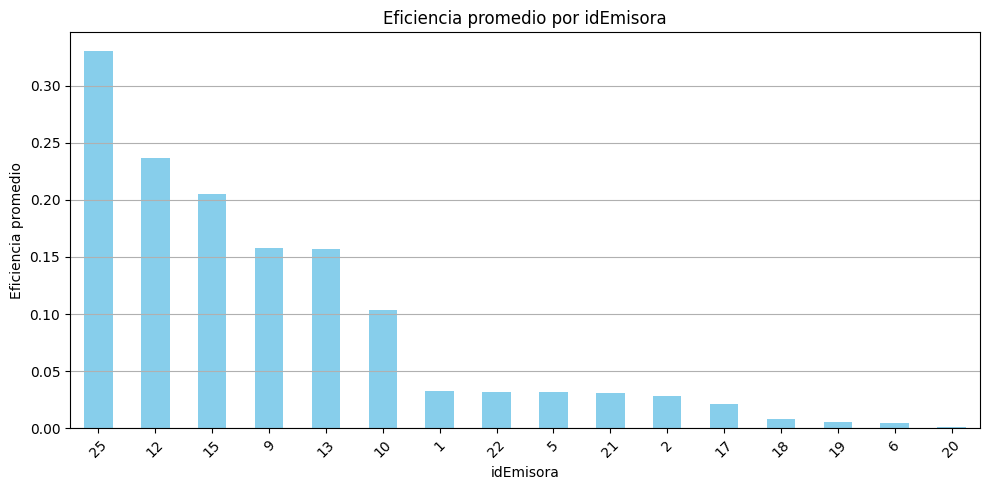

In [ ]:
# Agrupar por idEmisora y calcular eficiencia promedio
eficiencia_por_emisora = df.groupby('idEmisora')['pred_eficiencia'].mean().sort_values(ascending=False)

# Crear la gráfica
plt.figure(figsize=(10, 5))
eficiencia_por_emisora.plot(kind='bar', color='skyblue')
plt.title('Eficiencia promedio por idEmisora')
plt.xlabel('idEmisora')
plt.ylabel('Eficiencia promedio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


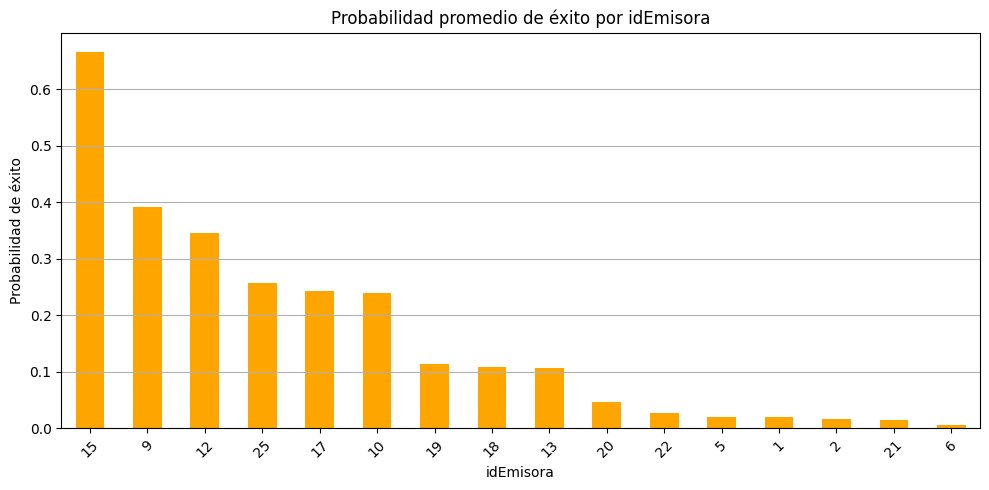

In [ ]:
# Agrupar por idEmisora y calcular probabilidad promedio
proba_por_emisora = df.groupby('idEmisora')['proba_exito_cobro'].mean().sort_values(ascending=False)

# Crear la gráfica
plt.figure(figsize=(10, 5))
proba_por_emisora.plot(kind='bar', color='orange')
plt.title('Probabilidad promedio de éxito por idEmisora')
plt.xlabel('idEmisora')
plt.ylabel('Probabilidad de éxito')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
